In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля
plt.style.use('ggplot')

# 1. Загрузка данных
try:
    df = pd.read_csv('famcs_students.csv')
except FileNotFoundError:
    print("Ошибка: Файл famcs_students.csv не найден. Убедитесь, что он в папке с ноутбуком.")

# 2. Определение целевой переменной
# N = 16, N % 8 = 0 -> ss
target_col = 'ss'

# 3. Отбор признаков (минимум 5)
# Мы выберем смесь числовых и категориальных признаков, которые могут влиять на то, является ли студент старостой
# score: средний балл
# miss: пропуски
# social: тип личности (экстраверт/интроверт)
# sex: пол
# work_experience: опыт работы
# ai: любимая нейронка (как показатель вовлеченности в технологии)

feature_cols = ['score', 'miss', 'social', 'sex', 'work_experience', 'ai']

# 4. Предобработка данных

# Кодирование целевой переменной (Да -> 1, Нет -> 0)
y = df[target_col].map({'Да': 1, 'Нет': 0}).values

# Кодирование признаков
X_df = df[feature_cols].copy()

# Словари для маппинга (сохраним их, чтобы понимать, что есть что)
mappings = {}

# Обработка категориальных признаков (Label Encoding)
cat_features = ['social', 'sex', 'work_experience', 'ai']
for col in cat_features:
    unique_vals = X_df[col].unique()
    mapping = {val: i for i, val in enumerate(unique_vals)}
    mappings[col] = mapping
    X_df[col] = X_df[col].map(mapping)

# Преобразование в numpy array
X = X_df.values.astype(float)

# Нормализация данных (StandardScaler) - критично для KNN и Логистической регрессии
# x_new = (x - mean) / std
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
# Избегаем деления на ноль, если колонка константная
std[std == 0] = 1 
X_scaled = (X - mean) / std

print(f"Целевая переменная: {target_col}")
print(f"Размер выборки: {X.shape}")
print(f"Распределение классов: {np.bincount(y)}")
print("Примеры закодированных данных (первые 3 строки):")
print(X_scaled[:3])

Целевая переменная: ss
Размер выборки: (127, 6)
Распределение классов: [113  14]
Примеры закодированных данных (первые 3 строки):
[[ 1.13016975 -0.55867931 -1.01945543 -0.70293502 -1.28067315 -1.3682403 ]
 [ 0.85528407 -0.32831479 -1.01945543  1.42260659 -0.2035507  -0.9838011 ]
 [ 0.85528407  0.24759651 -1.01945543  1.42260659 -1.28067315 -0.5993619 ]]


In [2]:
def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    # Фиксируем seed для воспроизводимости
    np.random.seed(42)
    
    indices = np.random.permutation(len(y))
    n_total = len(y)
    
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    train_idx = indices[:n_train]
    val_idx = indices[n_train : n_train + n_val]
    test_idx = indices[n_train + n_val:]
    
    return (X[train_idx], y[train_idx]), (X[val_idx], y[val_idx]), (X[test_idx], y[test_idx])

(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(X_scaled, y)

print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Val shapes:   X={X_val.shape}, y={y_val.shape}")
print(f"Test shapes:  X={X_test.shape}, y={y_test.shape}")

Train shapes: X=(88, 6), y=(88,)
Val shapes:   X=(19, 6), y=(19,)
Test shapes:  X=(20, 6), y=(20,)


In [3]:
def calculate_metrics(y_true, y_pred, y_proba=None):
    # Confusion Matrix elements
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-10)
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    roc_auc = 0.5
    if y_proba is not None:
        # Простой расчет ROC AUC через правило трапеций
        # Сортируем по вероятности убывания
        desc_score_indices = np.argsort(y_proba)[::-1]
        y_true_sorted = y_true[desc_score_indices]
        y_score_sorted = y_proba[desc_score_indices]
        
        tps = np.cumsum(y_true_sorted)
        fps = np.cumsum(1 - y_true_sorted)
        
        tpr = tps / tps[-1] if tps[-1] > 0 else np.zeros_like(tps)
        fpr = fps / fps[-1] if fps[-1] > 0 else np.zeros_like(fps)
        
        roc_auc = np.trapz(tpr, fpr)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': [[TN, FP], [FN, TP]]
    }

def print_metrics(model_name, metrics):
    print(f"--- {model_name} ---")
    for k, v in metrics.items():
        if k != 'Confusion Matrix':
            print(f"{k}: {v:.4f}")
    print(f"Confusion Matrix:\n{np.array(metrics['Confusion Matrix'])}")
    print("\n")

In [4]:
class TrivialClassifier:
    def fit(self, X, y):
        counts = np.bincount(y)
        self.majority_class = np.argmax(counts)
        self.proba = counts[1] / len(y) # Вероятность класса 1
        
    def predict(self, X):
        return np.full(X.shape[0], self.majority_class)
    
    def predict_proba(self, X):
        # Возвращаем константную вероятность
        return np.full(X.shape[0], self.proba)

# Обучение и оценка
trivial_model = TrivialClassifier()
trivial_model.fit(X_train, y_train)
y_pred_trivial = trivial_model.predict(X_test)
y_proba_trivial = trivial_model.predict_proba(X_test)

metrics_trivial = calculate_metrics(y_test, y_pred_trivial, y_proba_trivial)
print_metrics("Trivial Classifier", metrics_trivial)

--- Trivial Classifier ---
Accuracy: 0.9000
Precision: 0.0000
Recall: 0.0000
F1: 0.0000
ROC-AUC: 0.5833
Confusion Matrix:
[[18  0]
 [ 2  0]]




C:\Users\user\AppData\Local\Temp\ipykernel_15240\3207768336.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(tpr, fpr)


In [5]:
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.mean = {}
        self.var = {}
        self.priors = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0) + 1e-9 # Добавляем epsilon для стабильности
            self.priors[c] = X_c.shape[0] / X.shape[0]
            
    def _gaussian_pdf(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator
    
    def predict_proba(self, X):
        probas = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.priors[c])
                # Сумма логарифмов правдоподобия (log-likelihood)
                conditional = np.sum(np.log(self._gaussian_pdf(c, x)))
                posteriors.append(prior + conditional)
            
            # Softmax для перевода log-prob обратно в вероятности [0, 1]
            posteriors = np.array(posteriors)
            exp_post = np.exp(posteriors - np.max(posteriors)) # Shift для численной стабильности
            probas.append(exp_post / np.sum(exp_post))
            
        return np.array(probas)[:, 1] # Возвращаем вероятность класса 1

    def predict(self, X):
        # Если вероятность > 0.5, то класс 1
        return (self.predict_proba(X) > 0.5).astype(int)

# Обучение
nb_model = NaiveBayes()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
y_proba_nb = nb_model.predict_proba(X_test)

metrics_nb = calculate_metrics(y_test, y_pred_nb, y_proba_nb)
print_metrics("Naive Bayes (Gaussian)", metrics_nb)

--- Naive Bayes (Gaussian) ---
Accuracy: 0.9000
Precision: 0.0000
Recall: 0.0000
F1: 0.0000
ROC-AUC: 0.4444
Confusion Matrix:
[[18  0]
 [ 2  0]]




C:\Users\user\AppData\Local\Temp\ipykernel_15240\3207768336.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(tpr, fpr)


P(x | класс) = (1 / √(2πσ²)) × e^(-(x - μ)² / (2σ²))

Где:

    P(x | класс) - вероятность увидеть значение x при данном классе

    μ (mu) - среднее значение признака для этого класса

    σ² (sigma squared) - дисперсия (разброс) признака для этого класса

    π - число Пи (~3.14159)

    e - основание натурального логарифма (~2.71828)

Оптимальный k: 3 (Accuracy на валидации: 0.8947)


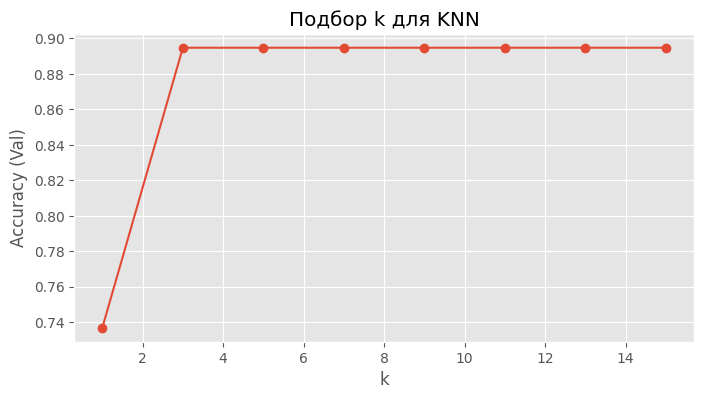

--- KNN (k=3) ---
Accuracy: 0.9000
Precision: 0.0000
Recall: 0.0000
F1: 0.0000
ROC-AUC: 0.4444
Confusion Matrix:
[[18  0]
 [ 2  0]]




C:\Users\user\AppData\Local\Temp\ipykernel_15240\3207768336.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(tpr, fpr)


In [6]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def _predict_one(self, x):
        # Евклидово расстояние (векторизованно)
        distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
        # Сортировка индексов
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        # Голосование
        counts = np.bincount(k_nearest_labels, minlength=2)
        return np.argmax(counts), counts[1] / self.k # Класс и вероятность
    
    def predict_proba(self, X):
        probas = [self._predict_one(x)[1] for x in X]
        return np.array(probas)
    
    def predict(self, X):
        preds = [self._predict_one(x)[0] for x in X]
        return np.array(preds)

# Подбор гиперпараметра k
best_k = 1
best_acc = 0
accuracies = []

# Перебираем нечетные k от 1 до 15
k_values = range(1, 16, 2)

for k in k_values:
    knn = KNN(k=k)
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)
    acc = np.mean(y_val_pred == y_val)
    accuracies.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_k = k

print(f"Оптимальный k: {best_k} (Accuracy на валидации: {best_acc:.4f})")

# График зависимости Accuracy от k
plt.figure(figsize=(8, 4))
plt.plot(k_values, accuracies, marker='o')
plt.title('Подбор k для KNN')
plt.xlabel('k')
plt.ylabel('Accuracy (Val)')
plt.show()

# Итоговая оценка на тесте
knn_final = KNN(k=best_k)
knn_final.fit(X_train, y_train)
y_pred_knn = knn_final.predict(X_test)
y_proba_knn = knn_final.predict_proba(X_test)

metrics_knn = calculate_metrics(y_test, y_pred_knn, y_proba_knn)
print_metrics(f"KNN (k={best_k})", metrics_knn)

Оптимальный порог: 0.1000 (F1 на валидации: 0.2222)


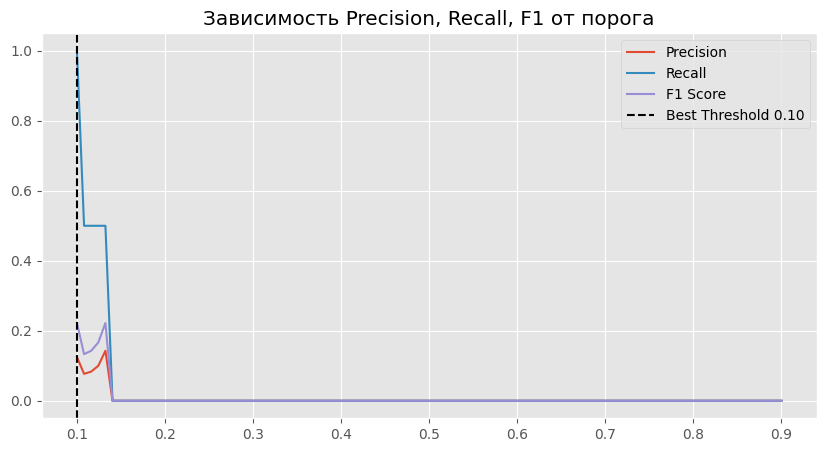

--- Logistic Regression ---
Accuracy: 0.2500
Precision: 0.0667
Recall: 0.5000
F1: 0.1176
ROC-AUC: 0.4722
Confusion Matrix:
[[ 4 14]
 [ 1  1]]




C:\Users\user\AppData\Local\Temp\ipykernel_15240\3207768336.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(tpr, fpr)


In [7]:
class LogisticRegressionCustom:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.threshold = 0.5
        
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Градиентный спуск
        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)
            
            # Градиенты
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            # Обновление весов
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)
    
    def predict(self, X):
        y_predicted_cls = [1 if i > self.threshold else 0 for i in self.predict_proba(X)]
        return np.array(y_predicted_cls)

# Обучение
log_reg = LogisticRegressionCustom(lr=0.1, epochs=2000)
log_reg.fit(X_train, y_train)

# Получаем вероятности на валидации для подбора порога
y_val_proba = log_reg.predict_proba(X_val)

thresholds = np.linspace(0.1, 0.9, 100)
precisions = []
recalls = []
f1_scores = []

best_f1 = -1
best_thresh = 0.5

for t in thresholds:
    y_temp_pred = (y_val_proba >= t).astype(int)
    m = calculate_metrics(y_val, y_temp_pred)
    precisions.append(m['Precision'])
    recalls.append(m['Recall'])
    f1_scores.append(m['F1'])
    
    if m['F1'] > best_f1:
        best_f1 = m['F1']
        best_thresh = t

print(f"Оптимальный порог: {best_thresh:.4f} (F1 на валидации: {best_f1:.4f})")

# График метрик от порога
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_thresh, color='black', linestyle='--', label=f'Best Threshold {best_thresh:.2f}')
plt.title('Зависимость Precision, Recall, F1 от порога')
plt.legend()
plt.show()

# Применение порога к модели
log_reg.threshold = best_thresh

# Оценка на тесте
y_pred_log = log_reg.predict(X_test)
y_proba_log = log_reg.predict_proba(X_test)

metrics_log = calculate_metrics(y_test, y_pred_log, y_proba_log)
print_metrics("Logistic Regression", metrics_log)

Итоговая сравнительная таблица (Test set):
                     Accuracy  Precision  Recall        F1   ROC-AUC
Trivial                  0.90   0.000000     0.0  0.000000  0.583333
Naive Bayes              0.90   0.000000     0.0  0.000000  0.444444
KNN                      0.90   0.000000     0.0  0.000000  0.444444
Logistic Regression      0.25   0.066667     0.5  0.117647  0.472222


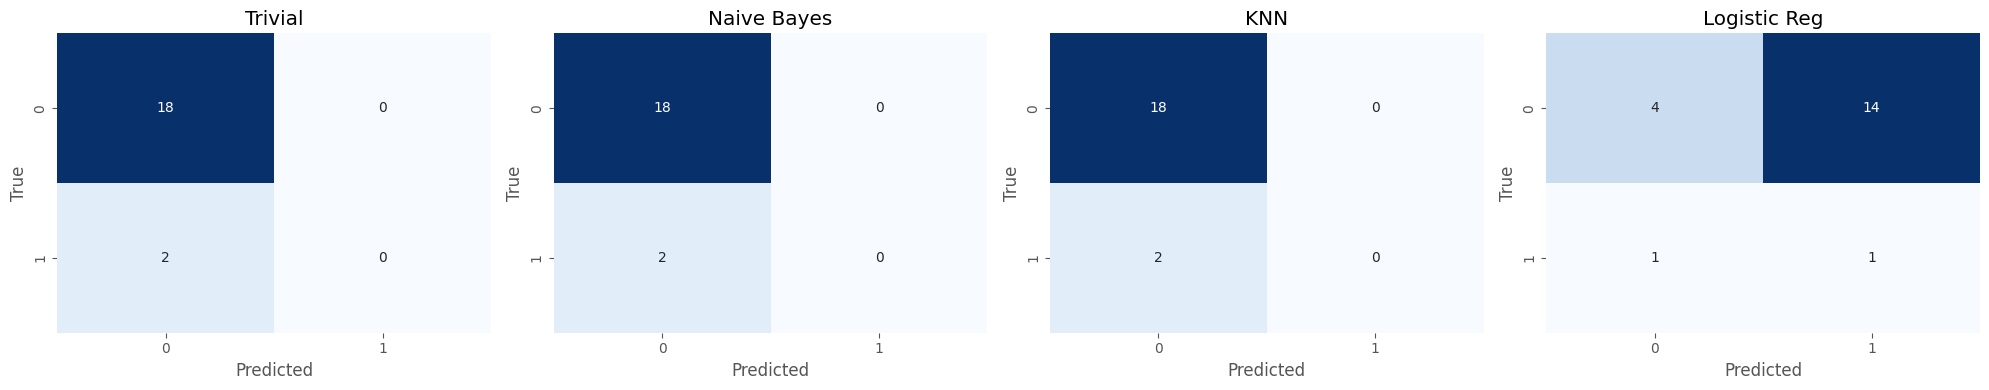

In [8]:
results = pd.DataFrame([
    metrics_trivial,
    metrics_nb,
    metrics_knn,
    metrics_log
], index=['Trivial', 'Naive Bayes', 'KNN', 'Logistic Regression'])

# Уберем матрицу ошибок из таблицы для красоты отображения
display_cols = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
print("Итоговая сравнительная таблица (Test set):")
print(results[display_cols])

# Визуализация Confusion Matrices
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
model_names = ['Trivial', 'Naive Bayes', 'KNN', 'Logistic Reg']
metric_list = [metrics_trivial, metrics_nb, metrics_knn, metrics_log]

for i, ax in enumerate(axes):
    cm = np.array(metric_list[i]['Confusion Matrix'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(model_names[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()